In [23]:
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# EDA

Through a series of graphs, I'll confirm or reject the following hypothesis: 
    
 >Humans all convey information at simliar rates, even though language structures are different

In [24]:
import pandas as pd
spoken_text = pd.read_csv('spoken-texts.csv')
languages = pd.read_csv('languages.csv')

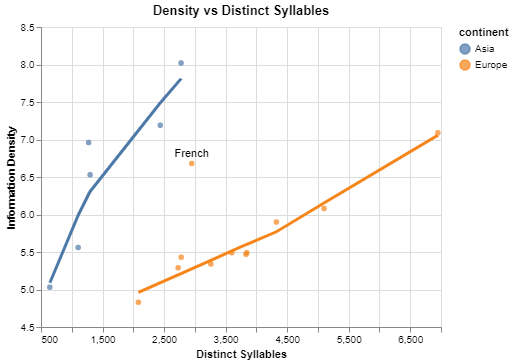

In [25]:
lang1 = alt.Chart(languages, title = "Density vs Distinct Syllables").mark_circle().encode(
    alt.X('distinct_syllables', scale=alt.Scale(zero=False),
         title = "Distinct Syllables"),
    alt.Y('information_density', scale=alt.Scale(zero=False),
         title = "Information Density"),
    color='continent',
    tooltip =('language'))

lang1_1 = lang1 + lang1.transform_loess(
     'distinct_syllables', 'information_density', groupby=['continent'], bandwidth=1).mark_line(size=3)

q1_1 = lang1_1 + alt.Chart(languages.query('language == "French"')).mark_text(dy=-10).encode(
    x='distinct_syllables',
    y="information_density",
    text='language')
q1_1 


-- Column specification --------------------------------------------------------
cols(
  speaker = col_character(),
  iso_lang = col_character(),
  text = col_character(),
  sex = col_character(),
  duration = col_double(),
  syllables = col_double(),
  age = col_double()
)


-- Column specification --------------------------------------------------------
cols(
  iso_lang = col_character(),
  language = col_character(),
  information_density = col_double(),
  distinct_syllables = col_double(),
  continent = col_character()
)



R[write to console]: `geom_smooth()` using formula 'y ~ x'



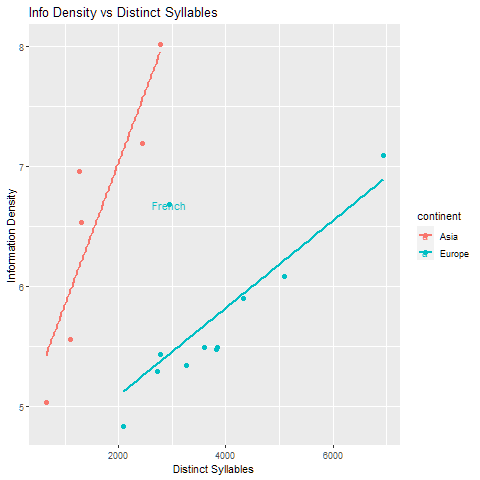

In [26]:
%%R
library(ggplot2)
library(tidyverse)
library(readr)
spoken_text <- read_csv("spoken-texts.csv")
languages <- read_csv("languages.csv")
languages_filtered <- languages %>% filter(language == "French")
# languages_filtered

q_1_2 <- ggplot(languages, aes(x=distinct_syllables, y=information_density, color = continent, label = language)) +
  geom_point(size=2)  +
    geom_smooth(se = FALSE, size = 1, method = "lm") + 
    xlab("Distinct Syllables")+
    ylab("Information Density")+
      geom_text(data = languages_filtered)+
ggtitle("Info Density vs Distinct Syllables")
q_1_2

# Review of Plots

In these 2 graphs, we saw that the Asian languages had less distinct syllables, while conveying more information per syllable. In contrast, the European languages had more unique syllables, while conveying less info per syllable. Through this first examination, we see that humans seem to communicate less information when they have more words to choose from. Could the increased information per syllable mean that Asian language speakers communicate faster? Is this debunking the hypothesis? 

# Speech rate and information density

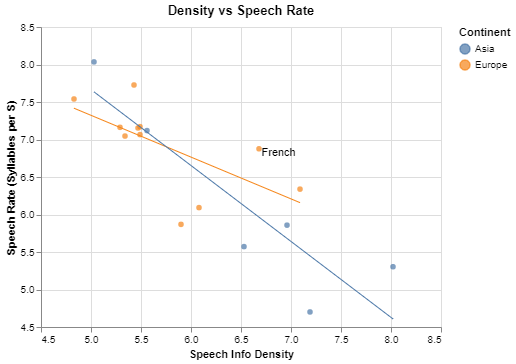

In [27]:
spoken_text["speech_rate"] = spoken_text["syllables"] / spoken_text["duration"]
languages = languages.merge(spoken_text.groupby("iso_lang")["speech_rate"].mean().reset_index())
# languages
spoken_language_merged_points = alt.Chart(
    languages, title = "Density vs Speech Rate").mark_circle().encode(
    alt.X('information_density', scale = alt.Scale(zero = False),
         title = "Speech Info Density"),
    alt.Y("speech_rate:Q", scale = alt.Scale(zero=False),
         title = "Speech Rate (Syllables per S)"),
    alt.Color("continent", title = "Continent"),
    tooltip = alt.Tooltip("language"))

spoken_lang_regress = spoken_language_merged_points + spoken_language_merged_points.transform_regression(
'information_density', 'speech_rate', groupby = ['continent']).mark_line(size =1) 
# first one should be X axis for this function ^^

q_2_1 = spoken_lang_regress + alt.Chart(languages.query(
    'language == "French"')).mark_text(dy=-10).encode(
    x='speech_rate:Q',
    y="information_density",
    text='language')

q_2_1

Joining, by = "iso_lang"


R[write to console]: `geom_smooth()` using formula 'y ~ x'



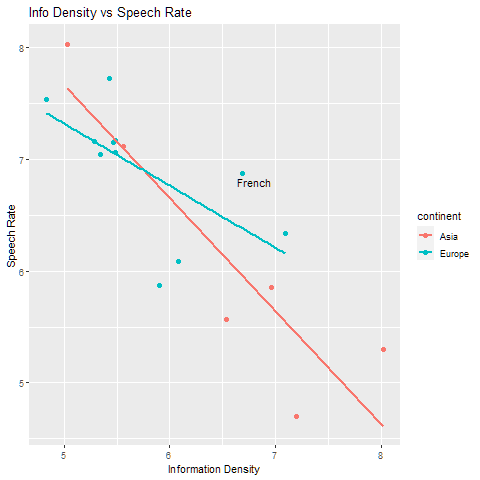

In [28]:
%%R
library(ggplot2)
library(tidyverse)
library(readr)
# spoken_text <- read_csv("spoken-texts.csv")
# languages <- read_csv("languages.csv")
# outlier_point_labels =languages %>% filter(language == "English" | language == "French")
      
speech_rate_df <- spoken_text %>% mutate(rate_temp = syllables / duration) %>%
nest(data = !iso_lang) %>% 
mutate(speech_rate = map_dbl(data, ~mean(.$rate_temp)))
speech_rate_df

spoken_text_merged <- left_join(languages, speech_rate_df, on = iso_lang)
spoken_text_merged

q_2_2 <- ggplot(spoken_text_merged, aes(x=information_density, y=speech_rate, 
                               color = continent)) +
  geom_point(size=2)  +
    geom_smooth(se = FALSE, size = 1, method = "lm") + 
    xlab("Information Density")+
    ylab("Speech Rate")+
    annotate('text', label = "French", x = 6.8, y = 6.8) +
ggtitle("Info Density vs Speech Rate")
    
q_2_2   

# Review 2

In these last graphs, we compared the speech rates for both languages. We found that European language speakers generally spoke faster than Asian speakers, which maybe means that it evens out their communication speed. But, the information density for these fast European speakers is still lower. Does this mean that the human brain can only handle so much input/output of languages? Let's explore information rate per language to really find out.

# Language information rate

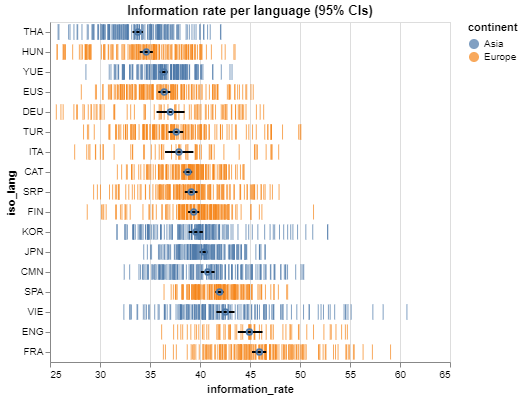

In [29]:
spo_q3 = pd.merge(spoken_text, languages, how='left', on='iso_lang')
spo_q3['information_rate'] = spo_q3['information_density']*spo_q3['syllables']/spo_q3['duration']
spo_final_df = spo_q3[['iso_lang','continent','information_rate']]
spo_list = spo_final_df.groupby('iso_lang').mean('information_rate').sort_values(
    by='information_rate').iloc[:,:0].index.tolist()

spoken_tick = alt.Chart(spo_final_df, title='Information rate per language (95% CIs)').mark_tick(color='light_grey').encode(
    x=alt.X('information_rate', scale=alt.Scale(zero=False)),
    y=alt.Y('iso_lang', sort=spo_list),
    color='continent')
err_bars = alt.Chart(spo_final_df).mark_errorbar(extent='ci', rule=alt.LineConfig(size=2)).encode(
  x=alt.X('information_rate'),
  y=alt.Y('iso_lang', sort=spo_list))
q_3_1 = spoken_tick + err_bars + err_bars.mark_point().encode(x='mean(information_rate)')

q_3_1

Joining, by = "iso_lang"


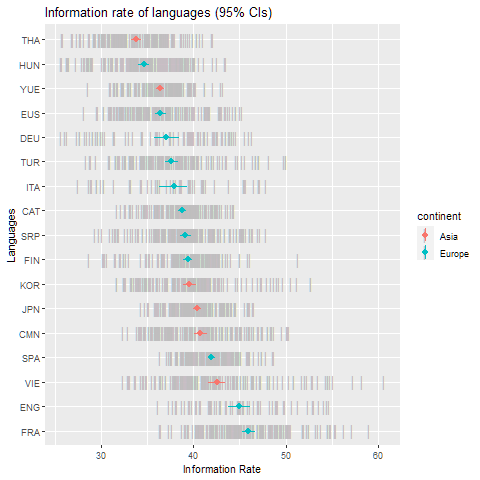

In [30]:
%%R
# library(Hmisc)
# spoken_text_merged
# languages_info_rate <- spoken_text_merged %>%
# mutate(information_rate = speech_rate * information_density)

lang_cols <- languages %>% select('iso_lang', 'information_density', 'continent')
spoken_joined <- inner_join(spoken_text, lang_cols)
merged_final <- spoken_joined %>%
mutate(information_rate = information_density * syllables / duration) %>%
group_by(iso_lang) %>%
mutate(mean_rate = mean(information_rate))

q_3_2 <- ggplot(merged_final) +
aes(x = information_rate, 
    y = reorder(iso_lang, -information_rate),
color = continent,
fill = continent) + 
geom_point(shape = '|', color = 'grey', size = 5) +
geom_pointrange(stat="summary", fun.data = mean_cl_boot, size = .5) +
ylab("Languages")+ 
xlab("Information Rate") +
ggtitle("Information rate of languages (95% CIs)")
q_3_2

## Review 3
We calculated the information rate of each language, and we found that actually - it was pretty spread out.

Overall, it seems like humans all communicate around the same speed of 35 to 46 information rate, even though their language syntax or speech rates are variable. So, we have accepted the hypothesis. Even if Asian languages convey more information per word, they generally speak slower, which limits the communication speed. Even if European languages convey less information per word, they generally speak faster. 

# Figure composition

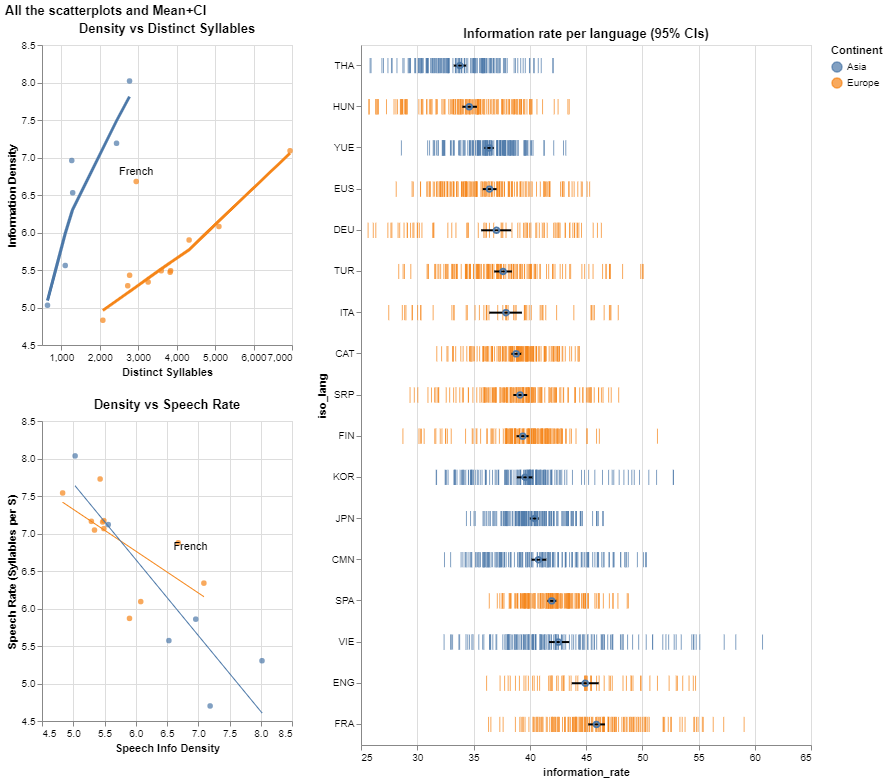

In [31]:
# from altair_saver import save
Py_fig_comp = (q1_1.properties(width = 250) & q_2_1.properties(
    width = 250) | q_3_1.properties(width = 450, height = 700)
             ).properties(title='All the scatterplots and Mean+CI')
Py_fig_comp

R[write to console]: `geom_smooth()` using formula 'y ~ x'

R[write to console]: `geom_smooth()` using formula 'y ~ x'



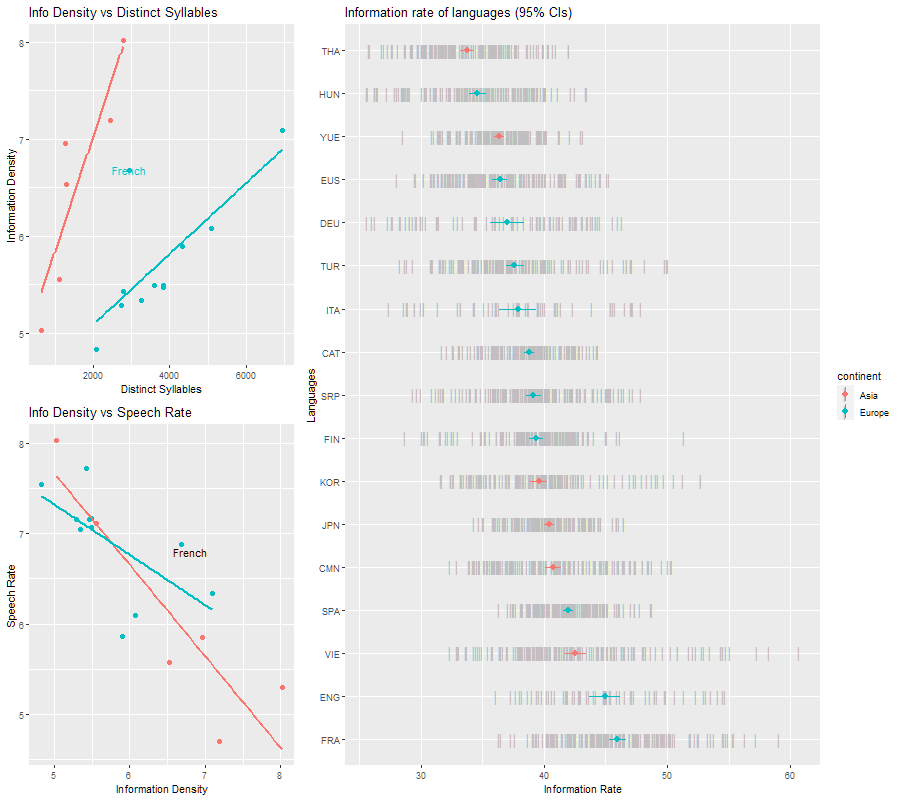

In [32]:
%%R -w 900 -h 800
library(cowplot)
grid1 <- plot_grid(q_1_2 + theme(legend.position="none"),
          q_2_2 + theme(legend.position="none"), ncol = 1)
grid2 <- plot_grid(grid1, q_3_2, rel_widths = c(1,2), rel_heights = c(2,2))
grid2
# plot_grid(plot_grid(q_1_2, q_2_2), q_3_2, ncol=1)

## Final review

This also means that over millenials of humans, our geography doesn't really affect our communication speed. Some languages from both continents are on the lower end of the third graph, while some languages from both are on the upper end of the third graph. This means that humans have preferred to speak/listen at simliar speeds.